# Postings Release Analysis: BGI vs Lightcast Comparison

In [6]:
# Snowflake connection setup
import snowflake.connector as snow
import pandas as pd
import os
import importlib.util

# Load credentials from config file
config_file_path = r"C:\Users\JuliaNania\OneDrive - Burning Glass Institute\Documents\Python\config.py"
spec = importlib.util.spec_from_file_location("config", config_file_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

# Establish connection
conn = snow.connect(
    user=config.credentials['USERNAME'],
    password=config.credentials['PASSWORD'],
    account='PCA67849',
    warehouse=config.credentials['WAREHOUSE'],
    database='PROJECT_DATA'
)
print("Connected to Snowflake")

Connected to Snowflake


In [7]:
# Helper function to run queries
def run_query(query):
    return pd.read_sql(query, conn)

## 2. Salary Key Stats Comparison
Comparing min, max, average, and median salary_min between BGI and Lightcast

In [3]:
# Salary stats: Lightcast (salary_from = salary_min)
lc_salary_query = """
SELECT 
    'Lightcast' AS SOURCE,
    MIN(SALARY_FROM) AS MIN_SALARY_MIN,
    MAX(SALARY_FROM) AS MAX_SALARY_MIN,
    AVG(SALARY_FROM) AS AVG_SALARY_MIN,
    MEDIAN(SALARY_FROM) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
"""
lc_salary = run_query(lc_salary_query)
display(lc_salary)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


,SOURCE,MIN_SALARY_MIN,MAX_SALARY_MIN,AVG_SALARY_MIN,MEDIAN_SALARY_MIN,N_POSTINGS_WITH_SALARY
0,Lightcast,9601,999998,55475.422084,41600.0,134782160


In [63]:
# Salary stats: BGI (convert hourly to yearly if salary_per != 'year')
# Assuming 2080 hours/year for hourly wages
bgi_salary_query = """
SELECT 
    'BGI' AS SOURCE,
    MIN(YEARLY_SALARY_MIN) AS MIN_SALARY_MIN,
    MAX(YEARLY_SALARY_MIN) AS MAX_SALARY_MIN,
    AVG(YEARLY_SALARY_MIN) AS AVG_SALARY_MIN,
    MEDIAN(YEARLY_SALARY_MIN) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS_WITH_SALARY
FROM (
    SELECT 
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' then NULL 
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        inner join temporary_data.dsexton.salary_infer_full_eval sal on sal.DESC_ID = p.DESC_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
)
"""
bgi_salary = run_query(bgi_salary_query)
display(bgi_salary)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,SOURCE,MIN_SALARY_MIN,MAX_SALARY_MIN,AVG_SALARY_MIN,MEDIAN_SALARY_MIN,N_POSTINGS_WITH_SALARY
0,BGI,0.000001,1.500002e+50,2.441717e+41,54280.0,614505599


In [14]:
# Combined salary comparison table
salary_comparison = pd.concat([lc_salary, bgi_salary], ignore_index=True)
display(salary_comparison.style.format('{:,.2f}', subset=['MIN_SALARY_MIN', 'MAX_SALARY_MIN', 'AVG_SALARY_MIN', 'MEDIAN_SALARY_MIN']))

,SOURCE,MIN_SALARY_MIN,MAX_SALARY_MIN,AVG_SALARY_MIN,MEDIAN_SALARY_MIN,N_POSTINGS_WITH_SALARY
0,Lightcast,"9,601.00","999,998.00","55,475.42","41,600.00",134782160
1,BGI,0.00,"150,000,188,000,315,004,833,395,410,836,932,845,428,953,957,007,360.00","244,171,686,321,658,839,900,495,716,805,094,185,893,888.00","54,280.00",614505599


## 1. Monthly Posting Counts Comparison (2025)
Comparing monthly job posting volumes between BGI and Lightcast

In [79]:
# Monthly posting counts: Lightcast US (2025)
lc_monthly_query = """
SELECT 
    DATE_TRUNC('month', POSTED) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE YEAR(POSTED) >= 2024 and posted < '2025-04-01'

GROUP BY 1
ORDER BY 1
"""
lc_monthly = run_query(lc_monthly_query)
lc_monthly['SOURCE'] = 'Lightcast'

# Monthly posting counts: BGI US (2025)
bgi_monthly_query = """
SELECT 
    DATE_TRUNC('month', POST_DATE) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) >= 2024 and post_date < '2025-04-01'
GROUP BY 1
ORDER BY 1
"""
bgi_monthly = run_query(bgi_monthly_query)
bgi_monthly['SOURCE'] = 'BGI'

# Combine for comparison
monthly_comparison = lc_monthly.merge(bgi_monthly, on='MONTH', suffixes=('_LC', '_BGI'))
monthly_comparison['MONTH_NAME'] = pd.to_datetime(monthly_comparison['MONTH']).dt.strftime('%b %Y')

display(monthly_comparison[['MONTH_NAME', 'POSTING_COUNT_LC', 'POSTING_COUNT_BGI']].style.format({
    'POSTING_COUNT_LC': '{:,.0f}',
    'POSTING_COUNT_BGI': '{:,.0f}'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,MONTH_NAME,POSTING_COUNT_LC,POSTING_COUNT_BGI
0,Jan 2024,"3,195,719","9,838,665"
1,Feb 2024,"3,016,118","8,187,423"
2,Mar 2024,"3,129,787","9,716,455"
3,Apr 2024,"2,961,945","9,002,684"
4,May 2024,"3,091,069","7,840,898"
5,Jun 2024,"3,044,619","8,133,246"
6,Jul 2024,"3,113,057","7,636,908"
7,Aug 2024,"3,322,788","8,544,433"
8,Sep 2024,"3,063,251","8,174,436"
9,Oct 2024,"3,307,902","8,413,402"


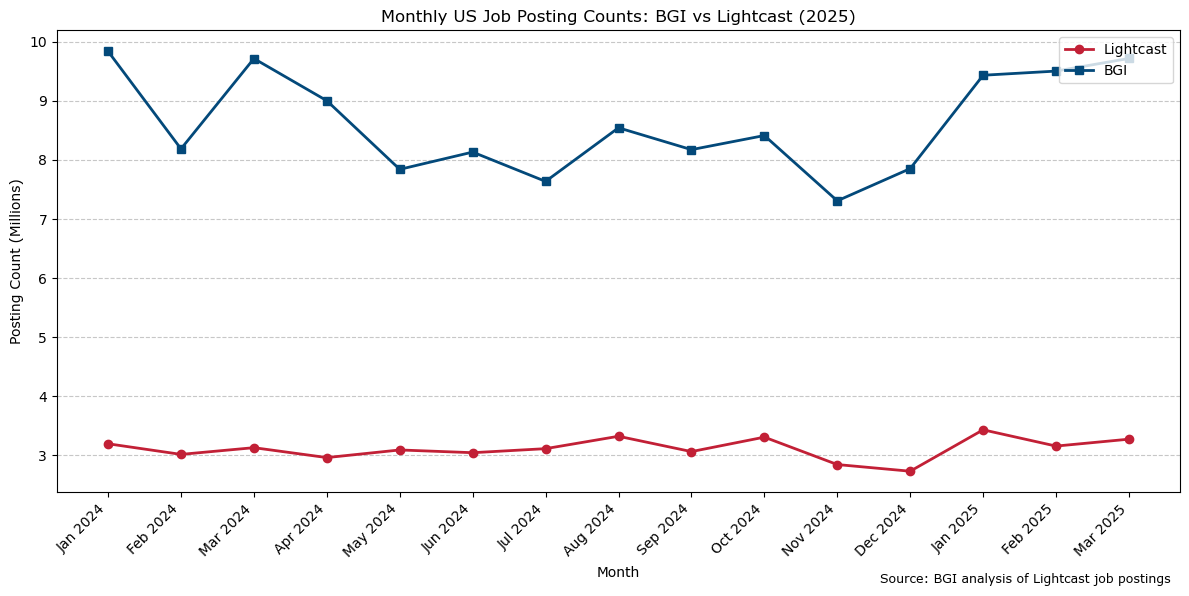

In [80]:
# Line chart: Monthly posting counts comparison
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(monthly_comparison['MONTH_NAME'], monthly_comparison['POSTING_COUNT_LC'] / 1e6, 
        marker='o', linewidth=2, label='Lightcast', color='#C22036')
ax.plot(monthly_comparison['MONTH_NAME'], monthly_comparison['POSTING_COUNT_BGI'] / 1e6, 
        marker='s', linewidth=2, label='BGI', color='#03497A')

ax.set_xlabel('Month', fontname='Verdana')
ax.set_ylabel('Posting Count (Millions)', fontname='Verdana')
ax.set_title('Monthly US Job Posting Counts: BGI vs Lightcast (2025)', fontname='Verdana')
ax.legend(loc='upper right')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

In [69]:
# Query salary distribution in $10k buckets up to $200k + one ">200k" bucket
# Filtered to year 2025 only
lc_dist_query = """
SELECT 
    CASE 
        WHEN SALARY_FROM > 200000 THEN 210000
        ELSE FLOOR(SALARY_FROM / 10000) * 10000 
    END AS SALARY_BUCKET,
    COUNT(*) AS COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2024
GROUP BY 1
ORDER BY 1
"""
lc_dist = run_query(lc_dist_query)

# Get total LC postings with salary for percentage calculation (2025 only)
lc_total = run_query("""
SELECT COUNT(*) AS TOTAL FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2024
""")['TOTAL'].iloc[0]

bgi_dist_query = """
SELECT 
    CASE 
        WHEN YEARLY_SALARY_MIN > 200000 THEN 210000
        ELSE FLOOR(YEARLY_SALARY_MIN / 10000) * 10000 
    END AS SALARY_BUCKET,
    COUNT(*) AS COUNT
FROM (
    SELECT 
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2024
)
GROUP BY 1
ORDER BY 1
"""
bgi_dist = run_query(bgi_dist_query)

# Get total BGI postings with salary for percentage calculation (2025 only)
bgi_total = run_query("""
SELECT COUNT(*) AS TOTAL FROM (
    SELECT 1
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2024
)
""")['TOTAL'].iloc[0]

# Convert to percentages based on full 2025 dataset
lc_dist['PCT'] = lc_dist['COUNT'] / lc_total * 100
bgi_dist['PCT'] = bgi_dist['COUNT'] / bgi_total * 100

# Merge to align buckets for charting
salary_dist = lc_dist[['SALARY_BUCKET', 'PCT']].rename(columns={'PCT': 'LC_PCT'}).merge(
    bgi_dist[['SALARY_BUCKET', 'PCT']].rename(columns={'PCT': 'BGI_PCT'}),
    on='SALARY_BUCKET', how='outer'
).fillna(0).sort_values('SALARY_BUCKET')

print(f"LC total postings with salary (2024): {lc_total:,}")
print(f"BGI total postings with salary (2024): {bgi_total:,}")

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



LC total postings with salary (2024): 19,517,297
BGI total postings with salary (2024): 166,616,851


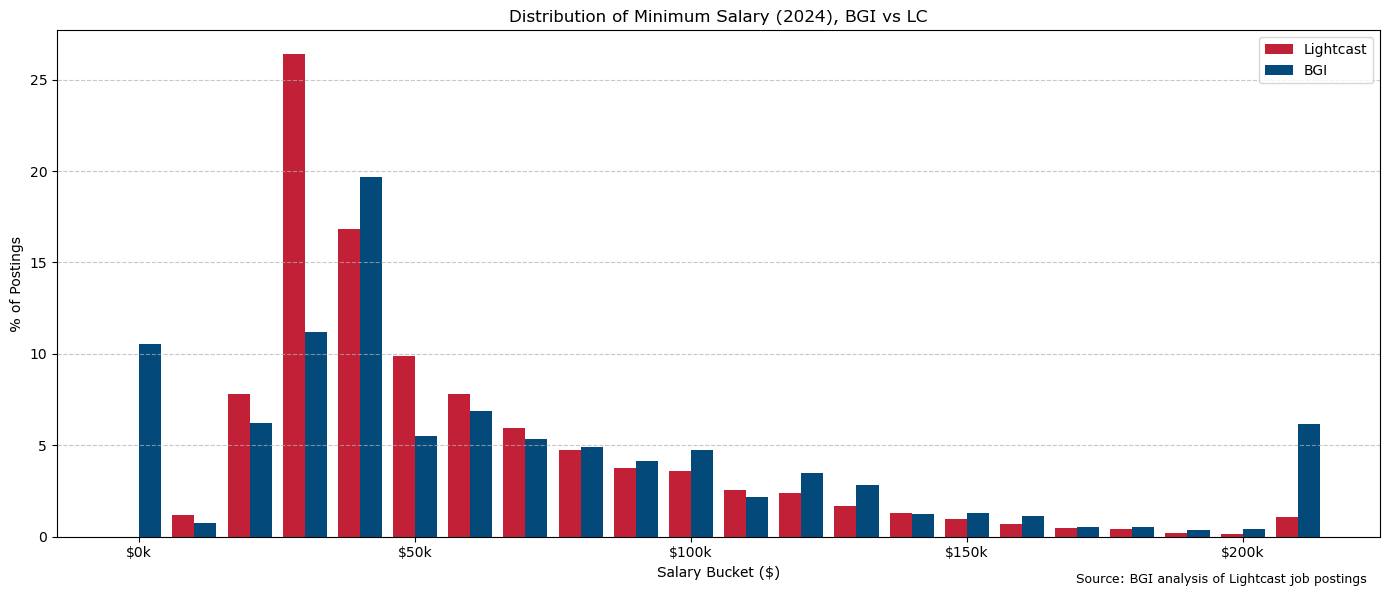

In [70]:
import matplotlib.pyplot as plt

# Chart: Salary distribution with >200k bucket (2024 only)
fig, ax = plt.subplots(figsize=(14, 6))
x = salary_dist['SALARY_BUCKET']
width = 4000

ax.bar(x - width/2, salary_dist['LC_PCT'], width, label='Lightcast', color='#C22036')
ax.bar(x + width/2, salary_dist['BGI_PCT'], width, label='BGI', color='#03497A')
ax.set_xlabel('Salary Bucket ($)', fontname='Verdana')
ax.set_ylabel('% of Postings', fontname='Verdana')
ax.set_title('Distribution of Minimum Salary (2024), BGI vs LC', fontname='Verdana')
ax.legend(loc='upper right')

# Custom formatter to show ">200k" for the 210000 bucket
def format_salary(x, _):
    if x == 210000:
        return '>$200k'
    return f'${x/1000:.0f}k'
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

# # Chart 2: Salaries above $200k
# fig, ax = plt.subplots(figsize=(12, 6))
# x = salary_dist_high['SALARY_BUCKET']
# width = 4000

# ax.bar(x - width/2, salary_dist_high['LC_PCT'], width, label='Lightcast', color='#C22036')
# ax.bar(x + width/2, salary_dist_high['BGI_PCT'], width, label='BGI', color='#03497A')
# ax.set_xlabel('Salary Bucket ($)', fontname='Verdana')
# ax.set_ylabel('% of Postings', fontname='Verdana')
# ax.set_title('Distribution of Minimum Salary (Above $200k)', fontname='Verdana')
# ax.legend(loc='upper right')
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))
# ax.yaxis.grid(True, linestyle='--', alpha=0.7)
# # fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
# #          ha='right', fontsize=9, fontname='Verdana')
# plt.tight_layout()
# plt.show()

## Examples of Very High Salary_Min in BGI Data
Examining outliers to understand data quality issues

In [22]:
# Examples of very high salary_min values with original SALARY_TEXT
high_salary_query = """
SELECT 
    sal.DESC_ID,
    sal.SALARY_TEXT,
    sal.PARSED_SALARY_MIN,
    sal.SALARY_PER,
    CASE 
        WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
        WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
        WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
        WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
        WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
        ELSE PARSED_SALARY_MIN
    END AS YEARLY_SALARY_MIN
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
    INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
  AND BGI_COUNTRY = 'United States'
ORDER BY YEARLY_SALARY_MIN DESC
LIMIT 50
"""
high_salary_examples = run_query(high_salary_query)
display(high_salary_examples)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,DESC_ID,SALARY_TEXT,PARSED_SALARY_MIN,SALARY_PER,YEARLY_SALARY_MIN
0,034e1e6159a100649eb84fe66c480475,Grammarly offers all team members competitive ...,1.500002e+50,year,1.500002e+50
1,5d652b5cf85c666cc7c41b73a3655b30,"CB Neptune Holdings, LLC has immediate availab...",9.506095e+44,NA,9.506095e+44
2,48923ef8721d5af45354bc7e3cb55d54,"Pay is based upon experience and, as establish...",5.180555e+44,NA,5.180555e+44
3,ea122cd92547212a93e52fb75124931e,2023-24 School Year Prior Years of Experience ...,3.367370e+44,NA,3.367370e+44
4,bd9df8a5cc484ace50415ec04c2af1ff,Pay based upon experience and as established b...,3.367370e+44,NA,3.367370e+44
5,6ad30c488020d8510429dd36e38f0055,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
6,f03e4e2abb902092fa79fd043fd657c6,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
7,a54c8c4d7755a1a8119c7ee80877618c,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
8,3a12696ca4714fa2482fc68f3de2c827,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
9,aae294ac02c47e7d2c66ec9532336ee2,Grammarly offers all team members competitive ...,1.570002e+44,year,1.570002e+44


## Examples of Very Low Salary_Min in BGI Data
Examining low-end outliers to understand data quality issues

In [25]:
# Examples of very low salary_min values with original SALARY_TEXT
low_salary_query = """
SELECT 
    sal.DESC_ID,
    sal.SALARY_TEXT,
    sal.PARSED_SALARY_MIN,
    sal.SALARY_PER,
    CASE 
        WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
        WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
        WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
        WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
        WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
        ELSE PARSED_SALARY_MIN
    END AS YEARLY_SALARY_MIN
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
    INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
  AND BGI_COUNTRY = 'United States'
ORDER BY YEARLY_SALARY_MIN ASC
LIMIT 20
"""
low_salary_examples = run_query(low_salary_query)
display(low_salary_examples)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,DESC_ID,SALARY_TEXT,PARSED_SALARY_MIN,SALARY_PER,YEARLY_SALARY_MIN
0,6b4f447a2ad21bb465742939a03645a0,"Overview: 0.000001- FTE, contingent position: ...",0.000001,NA,0.000001
1,50cb97409c1625c5b5a4461042244857,New employees are paid only by direct deposit ...,0.000005,NA,0.000005
2,50cb97409c1625c5b5a4461042244857,New employees are paid only by direct deposit ...,0.000005,NA,0.000005
3,f7032cdca1eb8c8eccc828d7bd3eb6f8,Position Type: Per Diem\n Shift Length: 8 hour...,0.000100,NA,0.000100
4,18ef92f5b1c16504cb38eda20528bab1,Position Type: Full-time\n Shift Length: 8-hou...,0.000100,NA,0.000100
5,8ff46c1af02d9af4c26722eb21a45111,Position Type: Full-time Shift Length: 8 hour ...,0.000100,NA,0.000100
6,53653f62151e89f24ca647229f7d6e02,"Schedule: Pool (PRN) FTE .0001, Day, variable",0.000100,NA,0.000100
7,fc2b910c6ce00f7e52afb6a534777333,Position Type: Full-time.\n Shift Length: 8-ho...,0.000100,NA,0.000100
8,18bb75b0b0b57c93596748e0efe9df66,**Position Type:** Full-time. **Shift Length:*...,0.000100,NA,0.000100
9,772f70f67dfe0fc634fd2908ae89dcd0,Work Type: PRN- FTE: 0.0001 - Per Diem Work Sc...,0.000100,NA,0.000100


## Median Min Salary by SOC 2 Occupation
Comparing median minimum salary across broad occupation categories

In [71]:
# Median min salary by SOC 2 occupation - Lightcast
lc_soc2_query = """
SELECT 
    SOC_2_NAME AS SOC2,
    MEDIAN(SALARY_FROM) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2024
  AND SOC_2_NAME IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
"""
lc_soc2 = run_query(lc_soc2_query)
lc_soc2['SOURCE'] = 'Lightcast'

# Median min salary by SOC 2 occupation - BGI
bgi_soc2_query = """
SELECT 
    lu.BGI_SOC2_NAME AS SOC2,
    MEDIAN(YEARLY_SALARY_MIN) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS
FROM (
    SELECT 
        p.ONET_CODE,
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) in ('piece', 'NA')  THEN NULL
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2024
) sub
INNER JOIN temporary_data.jnania.onet_soc_lookup lu ON lu.bgi_onet = sub.ONET_CODE
WHERE YEARLY_SALARY_MIN IS NOT NULL AND YEARLY_SALARY_MIN <= 500000
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_soc2 = run_query(bgi_soc2_query)
bgi_soc2['SOURCE'] = 'BGI'

# Merge for comparison
soc2_comparison = lc_soc2[['SOC2', 'MEDIAN_SALARY_MIN']].rename(columns={'MEDIAN_SALARY_MIN': 'LC_MEDIAN'}).merge(
    bgi_soc2[['SOC2', 'MEDIAN_SALARY_MIN']].rename(columns={'MEDIAN_SALARY_MIN': 'BGI_MEDIAN'}),
    on='SOC2', how='outer'
).fillna(0).sort_values('LC_MEDIAN', ascending=True)

display(soc2_comparison)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,SOC2,LC_MEDIAN,BGI_MEDIAN
9,Food Preparation and Serving Related Occupations,33280.0,30000.0
2,Building and Grounds Cleaning and Maintenance ...,35360.0,33000.0
11,Healthcare Support Occupations,37440.0,44000.0
8,"Farming, Fishing, and Forestry Occupations",37440.0,52000.0
18,Personal Care and Service Occupations,37440.0,43825.0
21,Sales and Related Occupations,39520.0,46940.0
20,Protective Service Occupations,39520.0,50000.0
19,Production Occupations,39520.0,46940.0
22,Transportation and Material Moving Occupations,39520.0,46940.0
17,Office and Administrative Support Occupations,39520.0,49260.0


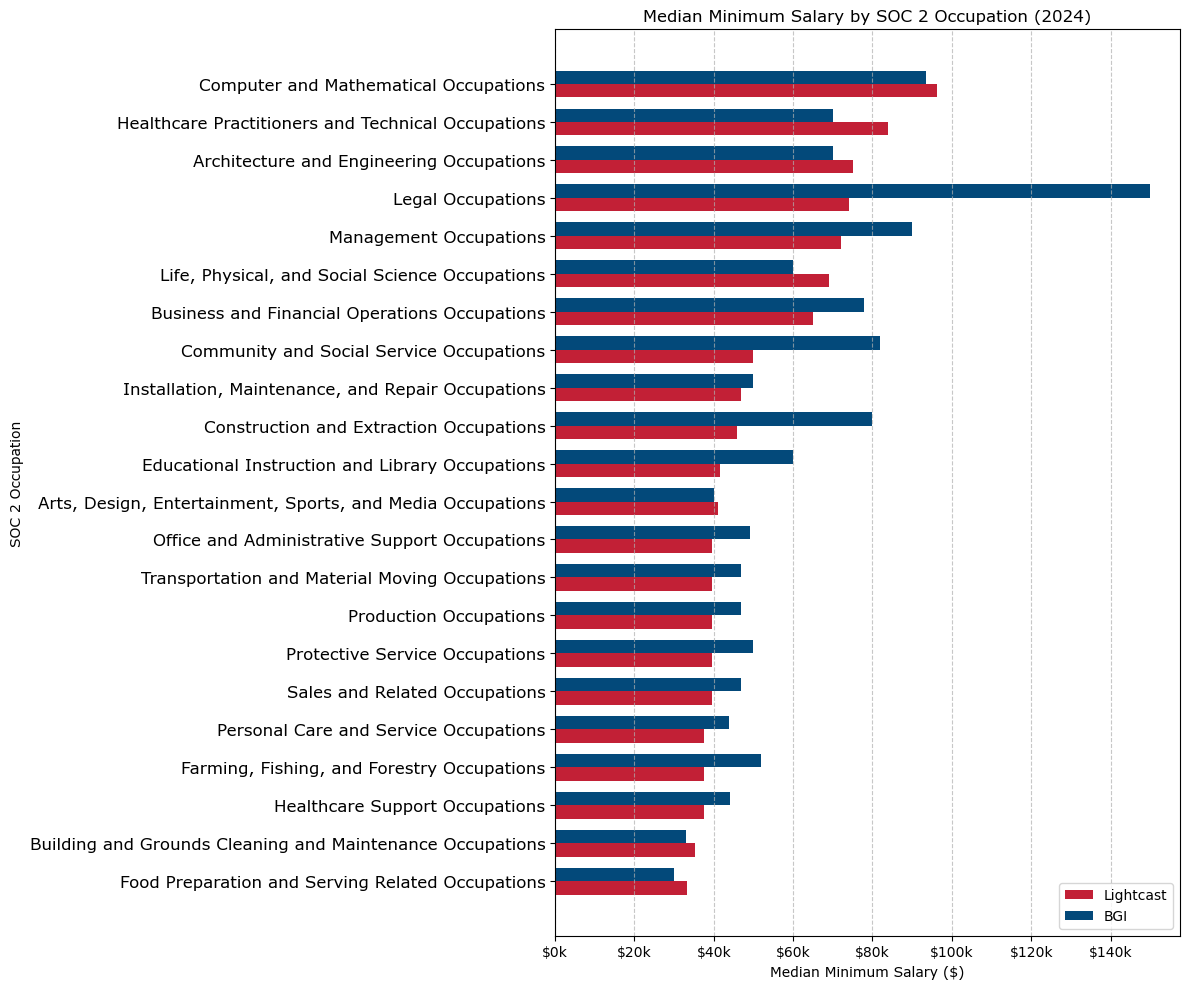

In [72]:
# Horizontal bar chart: Median min salary by SOC 2 occupation
import numpy as np

# Filter out military and unclassified occupations
soc2_chart = soc2_comparison[~soc2_comparison['SOC2'].str.lower().str.contains('military|unclassified', na=False)]

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(soc2_chart))
height = 0.35

ax.barh(y - height/2, soc2_chart['LC_MEDIAN'], height, label='Lightcast', color='#C22036')
ax.barh(y + height/2, soc2_chart['BGI_MEDIAN'], height, label='BGI', color='#03497A')

ax.set_xlabel('Median Minimum Salary ($)', fontname='Verdana')
ax.set_ylabel('SOC 2 Occupation', fontname='Verdana')
ax.set_title('Median Minimum Salary by SOC 2 Occupation (2024)', fontname='Verdana')
ax.set_yticks(y)
ax.set_yticklabels(soc2_chart['SOC2'], fontname='Verdana', fontsize=12)
ax.legend(loc='lower right')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
#          ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

In [73]:
# Analyze similarity between LC and BGI median salaries by SOC 2
from scipy import stats

# Use filtered data (exclude military/unclassified and rows with 0 values)
soc2_valid = soc2_chart[(soc2_chart['LC_MEDIAN'] > 0) & (soc2_chart['BGI_MEDIAN'] > 0)].copy()

# Calculate difference metrics
soc2_valid['DIFF'] = soc2_valid['LC_MEDIAN'] - soc2_valid['BGI_MEDIAN']
soc2_valid['ABS_DIFF'] = soc2_valid['DIFF'].abs()
soc2_valid['PCT_DIFF'] = (soc2_valid['DIFF'] / soc2_valid['LC_MEDIAN']) * 100

# Correlation
correlation, p_value = stats.pearsonr(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'])

# Summary statistics
print("=== Similarity Analysis: Median Min Salary by SOC 2 ===\n")
print(f"Number of SOC 2 categories compared: {len(soc2_valid)}")
print(f"\nCorrelation (Pearson r): {correlation:.3f} (p-value: {p_value:.4f})")
print(f"\nMean absolute difference: ${soc2_valid['ABS_DIFF'].mean():,.0f}")
print(f"Median absolute difference: ${soc2_valid['ABS_DIFF'].median():,.0f}")
print(f"\nMean % difference (LC vs BGI): {soc2_valid['PCT_DIFF'].mean():.1f}%")
print(f"Median % difference: {soc2_valid['PCT_DIFF'].median():.1f}%")

# Show detailed comparison
print("\n=== Detailed Comparison by SOC 2 ===")
display(soc2_valid[['SOC2', 'LC_MEDIAN', 'BGI_MEDIAN', 'DIFF', 'ABS_DIFF', 'PCT_DIFF']].sort_values('ABS_DIFF', ascending=False))

=== Similarity Analysis: Median Min Salary by SOC 2 ===

Number of SOC 2 categories compared: 22

Correlation (Pearson r): 0.706 (p-value: 0.0002)

Mean absolute difference: $13,727
Median absolute difference: $8,210

Mean % difference (LC vs BGI): -20.9%
Median % difference: -18.8%

=== Detailed Comparison by SOC 2 ===


,SOC2,LC_MEDIAN,BGI_MEDIAN,DIFF,ABS_DIFF,PCT_DIFF
13,Legal Occupations,74000.0,150000.0,-76000.0,76000.0,-102.702703
6,Construction and Extraction Occupations,45760.0,80000.0,-34240.0,34240.0,-74.825175
4,Community and Social Service Occupations,50000.0,81900.0,-31900.0,31900.0,-63.800000
7,Educational Instruction and Library Occupations,41600.0,60000.0,-18400.0,18400.0,-44.230769
15,Management Occupations,72000.0,90000.0,-18000.0,18000.0,-25.000000
8,"Farming, Fishing, and Forestry Occupations",37440.0,52000.0,-14560.0,14560.0,-38.888889
10,Healthcare Practitioners and Technical Occupat...,84000.0,70000.0,14000.0,14000.0,16.666667
3,Business and Financial Operations Occupations,65000.0,77800.0,-12800.0,12800.0,-19.692308
20,Protective Service Occupations,39520.0,50000.0,-10480.0,10480.0,-26.518219
17,Office and Administrative Support Occupations,39520.0,49260.0,-9740.0,9740.0,-24.645749


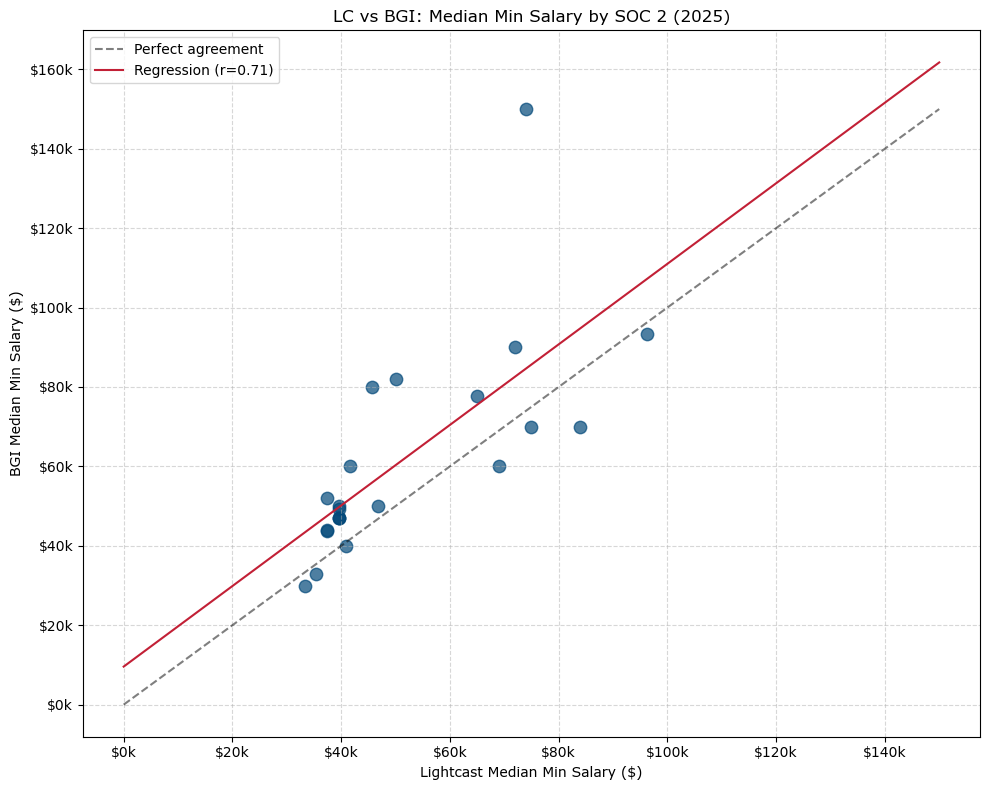

In [74]:
# Scatter plot: LC vs BGI median salary by SOC 2
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'], color='#03497A', s=80, alpha=0.7)

# Add diagonal reference line (perfect agreement)
max_val = max(soc2_valid['LC_MEDIAN'].max(), soc2_valid['BGI_MEDIAN'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect agreement')

# Add regression line
slope, intercept, r, p, se = stats.linregress(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'])
x_line = np.array([0, max_val])
ax.plot(x_line, slope * x_line + intercept, color='#C22036', label=f'Regression (r={r:.2f})')

ax.set_xlabel('Lightcast Median Min Salary ($)', fontname='Verdana')
ax.set_ylabel('BGI Median Min Salary ($)', fontname='Verdana')
ax.set_title('LC vs BGI: Median Min Salary by SOC 2 (2025)', fontname='Verdana')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y/1000:.0f}k'))
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Salary Coverage Analysis
What percentage of US job postings have a minimum salary?

In [75]:
# Salary coverage: % of postings with minimum salary (2025)

# Lightcast US coverage
lc_us_coverage_query = """
SELECT 
    'US' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE YEAR(POSTED) = 2024
"""
lc_us_coverage = run_query(lc_us_coverage_query)
lc_us_coverage['SOURCE'] = 'Lightcast'

# Lightcast UK coverage
lc_uk_coverage_query = """
SELECT 
    'UK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.UK_POSTINGS
WHERE YEAR(POSTED) = 2024
"""
lc_uk_coverage = run_query(lc_uk_coverage_query)
lc_uk_coverage['SOURCE'] = 'Lightcast'

# BGI US coverage
bgi_us_coverage_query = """
SELECT 
    'US' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(p.POST_DATE) = 2024
"""
bgi_us_coverage = run_query(bgi_us_coverage_query)
bgi_us_coverage['SOURCE'] = 'BGI'

# BGI UK coverage
bgi_uk_coverage_query = """
SELECT 
    'UK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'United Kingdom'
  AND YEAR(p.POST_DATE) = 2024
"""
bgi_uk_coverage = run_query(bgi_uk_coverage_query)
bgi_uk_coverage['SOURCE'] = 'BGI'

# Combine all
coverage_comparison = pd.concat([lc_us_coverage, lc_uk_coverage, bgi_us_coverage, bgi_uk_coverage], ignore_index=True)
coverage_comparison['PCT_WITH_SALARY'] = (coverage_comparison['POSTINGS_WITH_SALARY'] / coverage_comparison['TOTAL_POSTINGS']) * 100
coverage_comparison = coverage_comparison[['SOURCE', 'COUNTRY', 'TOTAL_POSTINGS', 'POSTINGS_WITH_SALARY', 'PCT_WITH_SALARY']]

print("=== Salary Coverage: Job Postings (2025) ===\n")
display(coverage_comparison.style.format({
    'TOTAL_POSTINGS': '{:,.0f}',
    'POSTINGS_WITH_SALARY': '{:,.0f}',
    'PCT_WITH_SALARY': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_45644\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or

=== Salary Coverage: Job Postings (2025) ===



,SOURCE,COUNTRY,TOTAL_POSTINGS,POSTINGS_WITH_SALARY,PCT_WITH_SALARY
0,Lightcast,US,"36,821,414","19,517,297",53.0%
1,Lightcast,UK,"8,916,019","4,336,601",48.6%
2,BGI,US,"514,769,417","166,616,851",32.4%
3,BGI,UK,"17,064,962","6,913,971",40.5%
